# Step 3: Analyzing the data

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import scipy.stats
from scipy import spatial
from scipy import optimize
from scipy import special

In [2]:
domain = pd.read_csv("domain3d.csv")
data = pd.read_csv("data3d.csv")

In [3]:
data.head()

,X,Y,Z,Property
0,2037.5,199.16667,1138.0802,22.308119
1,1062.5,66.94444,1188.2911,21.838218
2,87.5,133.05556,585.7595,20.663617
3,1062.5,66.94444,1087.8691,26.171619
4,1337.5,199.16667,1238.5021,29.369300


In [4]:
mean = np.mean(data['Property'])
max_val = np.max(data['Property'])
min_val = np.min(data['Property'])
print("mean = %f" %mean)
print("max = %f" %max_val)
print("min = %f" %min_val)
variance = np.var(data['Property'])
std = np.sqrt(variance)
print("standard deviation = %f" %std)

mean = 20.810656
max = 38.031110
min = 2.775717
standard deviation = 6.734521


Text(0.5,1,'(b) Cumulative histogram using 50 bins')

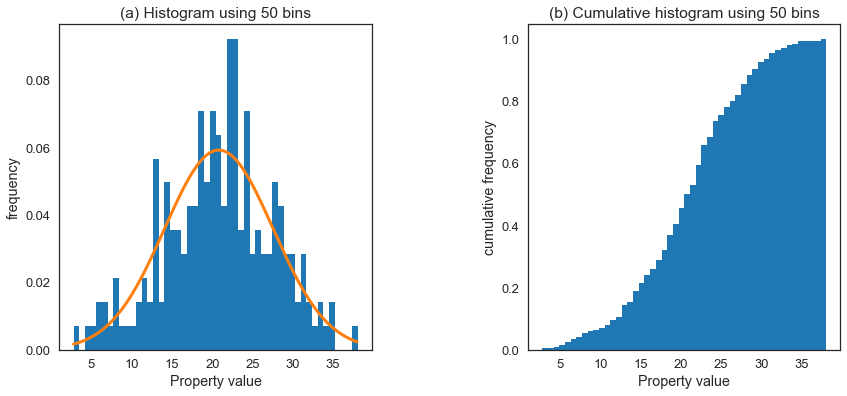

In [5]:
#show histogram (normal and cumulative)
fig4 = plt.figure(figsize = (14, 6)) 
fig4.subplots_adjust(wspace=.5)
bin_amount = 50

ax41 = fig4.add_subplot(121)
ax42 = fig4.add_subplot(122)

x_vals = np.arange(min_val, max_val, 0.1)

ax41.hist(data['Property'], bins=bin_amount, normed=True);
ax41.plot(x_vals, scipy.stats.norm.pdf(x_vals, mean, std), lw = 3)
ax41.set_xlabel("Property value")
ax41.set_ylabel("frequency")
ax41.set_title('(a) Histogram using %i bins' %bin_amount)

ax42.hist(data['Property'], bins=bin_amount, normed=True, cumulative=True);
ax42.set_xlabel("Property value")
ax42.set_ylabel("cumulative frequency")
ax42.set_title('(b) Cumulative histogram using %i bins' %bin_amount)

In [6]:
pos = 0
h = np.empty((len(data), len(data)))
gamma = np.empty((len(data), len(data)))

data_m = data.as_matrix(('X','Y','Z'))
data_v = data['Property'].values


for pos in range (len(data)):
    for i in range (len(data)):
        gamma[pos, i] = ((data_v[i]-data_v[pos])**2)/2
        h[pos, i] = spatial.distance.euclidean(data_m[i], data_m[pos])

In [7]:
bins = bin_amount
maxim = 2000
bin_size = maxim/bins
a = 0

h_bins = np.empty(bins)
ave_vals = np.empty(bins)

for j in range (bins):
    bi = np.where((h > a)*(h < (a+bin_size)))
    ave_vals[j] = np.average(gamma[bi])
    h_bins[j] = (a+a+bin_size)/2
    a += bin_size

In [8]:
def gaussian_variogram_model(d, range_, sill):
    nugget = 10
    psill = sill
    gamma = psill * (1. - np.exp(-d**2./(range_)**2.)) + nugget
    return gamma

In [9]:
# fitting best gaussian variogram model, have to find a generic way to determine the bounds, probably half size of domain
gaussian_fit = scipy.optimize.curve_fit(gaussian_variogram_model, h_bins, ave_vals, bounds=(0,2000))

In [10]:
gaussian_range = gaussian_fit[0][0]
gaussian_sill = gaussian_fit[0][1]
print(gaussian_range)
print(gaussian_sill)
h = np.arange(0, 2000, 0.1)

169.36528444850867
38.15827598216441


(0, 65.92741673961574)

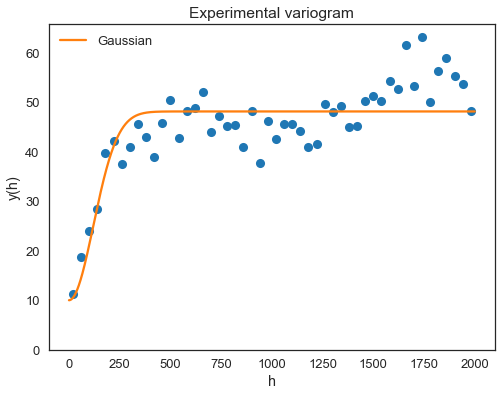

In [11]:
#plot figure
plt.figure(figsize=(8,6))
plt.plot(h_bins, ave_vals,'o')
plt.xlabel("h")
plt.ylabel("y(h)")
plt.title('Experimental variogram')
plt.plot(h, gaussian_variogram_model(h, gaussian_range, gaussian_sill),'-',label='Gaussian')
plt.legend(loc ='best')
plt.ylim(0)

In [12]:
a= gaussian_range
b = gaussian_sill

In [13]:
d = {'Range': [a], 'Sill': [b]}
variogram_fit = pd.DataFrame(data=d)
variogram_fit.head()

,Range,Sill
0,169.365284,38.158276


In [14]:
variogram_fit.to_csv("variogram_fit.csv", index=False)